# Predicting Off-Topic Questions on StackOverflow

## Motivation
        
On StackOverflow, users post questions about programming problems they’ve encountered while trying to solve other problems such as this one. StackOverflow has particular rules about what is a valid question to ask, usually requiring that they be **on topic, detailed, and not a duplicate of another question.** There’s a process for closing questions that violate these rules, however it requires manual intervention!

Let’s say that hypothetically their product team has come to you and wants to know: **_can they tell users that their post is likely to be closed for off-topic before they even post it?_**

## Dataset
-  50K randomly sampled posts _that have been closed as off-topic_ (indicated by 1 in the label columns)
-  50k randomly sampled posts _that haven’t been closed and have an accepted answer_ (indicated by 0 in the label column).
-  **Notes:** 
    * Balanced dataset. 
    * 'Off-Topic' is the positive class.

Dataset in csv format (utf-8 encoded) can be found [here](https://s3.amazonaws.com/techblog-static/interview_dataset.csv) (~215MB) and there are five columns:

   1. **Title**
        1. This is the title of the post that a user has submitted
   2. **Body**
        1. This is the body of the post that the user submitted
   3. **label**
        1. Either 0 or 1 to indicate acceptable versus off-topic posts respectively
   4. **Title_processed**
        1. see below
   5. **Body_processed**
        1. see below

To save you some time, we’ve also run the post Body and Title through a text normalization pipeline. These are in columns Body_processed and Title_processed respectively -- however you are free to ignore them and write your own text processing pipeline if you think it’s worthwhile!

## Actual Problem
This problem is fundamentally a predictive analytics problem -- **_investigate and develop an algorithm that is able to classify whether or not a given post is going to be closed as off-topic, using solely the provided Body and Title_**. While we’re not going to require that you develop a machine learning approach to this problem, we’ll suggest that it’s going to be a much easier route that trying to develop some hard-coded heuristics.

In [79]:
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import path
%matplotlib inline
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

## 1. Munge and explore data
#### Let's import and examine our data

In [80]:
df = pd.read_csv("../Downloads/interview_dataset.csv")

print("Shape of dataframe: " + str(df.shape))
print("There are " + str(df.shape[0]) + " rows.")
print("There are " + str(df.shape[1]) + " columns.")
df.head(10)

Shape of dataframe: (100000, 6)
There are 100000 rows.
There are 6 columns.


,Unnamed: 0,Body,Title,label,Body_processed,Title_processed
0,33226,<p>Hi I'm new to <code>Ruby on Rails</code>. I...,RUBY: most common number for Users,1,hi i'm new to ruby on rails . i created users ...,ruby : most common number for users
1,64804,<p>I know that StringBuffer class is synchroni...,What exactly does it mean when they say that S...,0,i know that stringbuffer class is synchronized...,what exactly does it mean when they say that s...
2,39763,<p>I have a search engine on PHP that have ind...,Scan a webpage and get the video embed url only,1,i have a search engine on php that have indexe...,scan a webpage and get the video embed url only
3,51270,<p>Is there any way to get ICY metadata from s...,ICY metadata support with ffmpeg,0,is there any way to get icy metadata from shou...,icy metadata support with ffmpeg
4,9698,<p>For my website I want to have divs out of t...,Use jQuery or Javascript to move elements into...,1,for my website i want to have divs out of the ...,use jquery or javascript to move elements into...
5,5948,<p>I'm looking for a dead simple Java Library ...,Java SFTP Transfer Library,1,i'm looking for a dead simple java library to ...,java sftp transfer library
6,27955,<p>Having two MySql databases with same struct...,How to Merge two Mysql Databases with same str...,1,having two mysql databases with same structure...,how to merge two mysql databases with same str...
7,55001,<p>Hi I have 3 soap requests. \nSay.\nReq1 \nR...,How can I pipeline multiple soap requests usin...,0,hi i have 3 soap requests . say . req1 req2 re...,how can i pipeline multiple soap requests usin...
8,50875,<p>Consider the following entity-relationship ...,Mapping many-to-many relationship with attribu...,0,consider the following entity - relationship d...,mapping many - to - many relationship with att...
9,47755,<p>I tried to make a program to get the amount...,C++ do while loop,1,i tried to make a program to get the amount af...,c ++ do while loop


Column 0 is titled 'Unnamed: 0' by default from the import
<br>
Let's see if it's a unique number. If so, let's make it a unique ID for every entry

In [81]:
df['Unnamed: 0'].nunique()

100000

Ok, it's unique. Let's rename it to 'id' and we can possibly use it in our analysis

In [82]:
# rename column
df.columns = ['id' if x=='Unnamed: 0' else x for x in df.columns]

# get column names to confrim.
df.dtypes.index

Index(['id', 'Body', 'Title', 'label', 'Body_processed', 'Title_processed'], dtype='object')

##### Check for any NaN's or duplicates
Remove if desired

In [83]:
# find NaN's

df.isnull().sum().sum()

# 2 rows with NaN values. Pretty good. Let's see what these 2 look like.

2

In [84]:
# check what Nan's look like. Just to pass they eye test.

df2 = df[df.isnull().any(axis=1)]
print(df2.shape)
df2.head()

# Let's just remove these 2.

(2, 6)


,id,Body,Title,label,Body_processed,Title_processed
26633,74726,<p>script async not working:</p>\n\n<pre><code...,<script async> not working in rails,0,script async not working : < h1 > welcome # in...,NaN
90392,65968,<p>In my JSF+Spring project i tried to add for...,<rich:popupPanel buttons not working in JSF Pr...,0,in my jsf + spring project i tried to add form...,NaN


In [85]:
# drop Nan's
df = df.dropna()
df.shape

# drop duplicates
df = df.drop_duplicates(subset=['Body', 'Title', 'label', 'Body_processed', 'Title_processed'], keep=False)
df.shape

df.head(10)

,id,Body,Title,label,Body_processed,Title_processed
0,33226,<p>Hi I'm new to <code>Ruby on Rails</code>. I...,RUBY: most common number for Users,1,hi i'm new to ruby on rails . i created users ...,ruby : most common number for users
1,64804,<p>I know that StringBuffer class is synchroni...,What exactly does it mean when they say that S...,0,i know that stringbuffer class is synchronized...,what exactly does it mean when they say that s...
2,39763,<p>I have a search engine on PHP that have ind...,Scan a webpage and get the video embed url only,1,i have a search engine on php that have indexe...,scan a webpage and get the video embed url only
3,51270,<p>Is there any way to get ICY metadata from s...,ICY metadata support with ffmpeg,0,is there any way to get icy metadata from shou...,icy metadata support with ffmpeg
4,9698,<p>For my website I want to have divs out of t...,Use jQuery or Javascript to move elements into...,1,for my website i want to have divs out of the ...,use jquery or javascript to move elements into...
5,5948,<p>I'm looking for a dead simple Java Library ...,Java SFTP Transfer Library,1,i'm looking for a dead simple java library to ...,java sftp transfer library
6,27955,<p>Having two MySql databases with same struct...,How to Merge two Mysql Databases with same str...,1,having two mysql databases with same structure...,how to merge two mysql databases with same str...
7,55001,<p>Hi I have 3 soap requests. \nSay.\nReq1 \nR...,How can I pipeline multiple soap requests usin...,0,hi i have 3 soap requests . say . req1 req2 re...,how can i pipeline multiple soap requests usin...
8,50875,<p>Consider the following entity-relationship ...,Mapping many-to-many relationship with attribu...,0,consider the following entity - relationship d...,mapping many - to - many relationship with att...
9,47755,<p>I tried to make a program to get the amount...,C++ do while loop,1,i tried to make a program to get the amount af...,c ++ do while loop


#### Let's confirm balanced data

label
0    49998
1    49879
dtype: int64


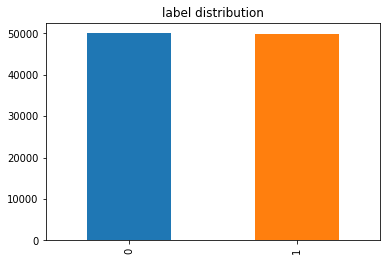

In [86]:
pd.value_counts(df['label']).plot.bar().set_title('label distribution')
print(df.groupby(['label']).size())

## Tokenize the raw data
#### We need to convert our text data into integers so that we can use them in our model
Let's convert our input and label data into lists so they can be used in the keras tokenizer

We choose to use the 'Body_processed' as input for it's more robust description

In [87]:
# tokenize the raw data

# USE EITHER TITLE OR BODY

# get title_processed and labels
texts = list(df.Body_processed)
print(type(texts))

labels = list(df.label)
print(type(labels))

<class 'list'>
<class 'list'>


#### Let's tokenize and see how many unique words there are in our data

In [88]:
maxlen = 200 # Cuts off title text after 20 words
max_words = 20000 # considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 366678 unique tokens.


We found 366,678 unique tokens in our body data.

This seems like alot. According to Oxford dictionaries there only 171,476 words in the english language.

Let's acknowledge that a 'token' is a group of characters and that our dataset includes domain specific and technical words which may not be common in the english language. (i.e. Drupal, AWS, C++)

Let's acknowledge this fact and move forward with our analysis

#### Pad sequences so that the vectors are of even length.
Keras prefers inputs to vectorized and all inputs to have the same length. We will pad all input sequences (body) to a lenght of 200 words. It will take the first 200 words from a body. If body is less than 200 words it will pad the vector with zeros.

In [89]:
# pad sequences so vectors are of even length
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print("Shape of data tensor:", data.shape, "and is of type:", type(data))
print("Shape of label tensor:", labels.shape, "and is of type:", type(labels))
print(data)

Shape of data tensor: (99877, 200) and is of type: <class 'numpy.ndarray'>
Shape of label tensor: (99877,) and is of type: <class 'numpy.ndarray'>
[[   0    0    0 ...  406  186  116]
 [   0    0    0 ...   29  231 1003]
 [   0    0    0 ...   26  399  130]
 ...
 [   0    0    0 ...   12   27  417]
 [3488   27  230 ...  488  538   33]
 [   0    0    0 ...  562    3  102]]


#### Split data into training, validation and test set
We have a validation set for hyperparameter tuning and a held out test set to evaluate our model.

There are a number of possible configurations but we decided on 40/40/20 train/val/test split

In [90]:
# First shuffle the data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [91]:
# split data

training_samples = 40000 # trains on 40000 samples
validation_samples = 40000 # validates on 40000 samples

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
x_test = data[training_samples + validation_samples:]
y_test = labels[training_samples + validation_samples:]

print("Shape of x_train tensor:", x_train.shape, "and is of type:", type(x_train))
print("Shape of y_train tensor:", y_train.shape, "and is of type:", type(y_train))
print("Shape of x_val tensor:", x_val.shape, "and is of type:", type(x_val))
print("Shape of y_val tensor:", y_val.shape, "and is of type:", type(y_val))
print("Shape of x_test tensor:", x_test.shape, "and is of type:", type(x_test))
print("Shape of y_test tensor:", y_test.shape, "and is of type:", type(y_test))

Shape of x_train tensor: (40000, 200) and is of type: <class 'numpy.ndarray'>
Shape of y_train tensor: (40000,) and is of type: <class 'numpy.ndarray'>
Shape of x_val tensor: (40000, 200) and is of type: <class 'numpy.ndarray'>
Shape of y_val tensor: (40000,) and is of type: <class 'numpy.ndarray'>
Shape of x_test tensor: (19877, 200) and is of type: <class 'numpy.ndarray'>
Shape of y_test tensor: (19877,) and is of type: <class 'numpy.ndarray'>


##### Ok, now are data is prepared for modeling

## 2. Model


### Embedding
In an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space. Whereas the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same dimensionality as the number of words in the vocabulary), word embeddings are low-dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vectors)

Keras has an embedding layer that can be used for neural networds on text data. It requires the input data to be integer encoded (which we did in the tokenizer step). The embedding layer is initialized with random weights and will learn an embedding for all of the words in our training set. There are also pretrained word embeddings (Word2Vec and GloVe).

In Keras, if you wish to connect a Dense layer directly to an embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer.

<img src="http://gpucomputing.shef.ac.uk/static/img/intro_dl_sharc_dgx1/embedding.png">

###  2.a Model - Embedding layer with a classifier

In [92]:
maxlen = 200 # Cuts off text after X words
max_words = 20000 # considers only the top X words in the dataset

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten()) # flattens 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen*embedding_dim)
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size=64,
                   validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 32)           640000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                204832    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 844,865
Trainable params: 844,865
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 303us/step - loss: 0.4977 - acc: 0.7597 - val_loss: 0.4637 - val_acc: 0.7792
Epoch 2/10
40000/40000 [==============================] - 13s 328us/step - loss

#### Score our model on the test set

In [93]:
# Final evaluation of the model on test set
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test set accuracy: %.2f%%" % (scores[1]*100))

Test set accuracy: 67.65%


#### Plot the model's performance over time

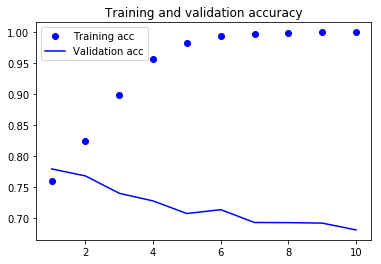

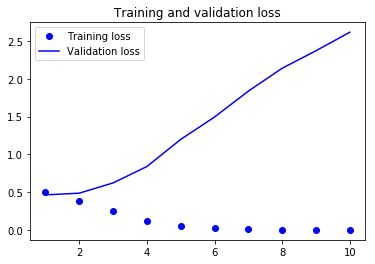

In [94]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Wow, looks like we rapidly start over fitting. Let's look how we can address that later.

### 2.b Model - Simple RNN

#### Recurrent Neural Networks (RNN)
A characterstic of the previous model is that it has no memory. Each input show to the model is processed independently, with no state kept in between inputs. In order to process a sequence of data points, you have to show the entire sequence to the network at once. This is what we did in the previous model, and entire body was transformed into a single large vector and processed in one go. These networks are called feedforward networks.

A recurrent neural network processes sequences by iterating through the sequence elements and maintaining a state containing information relative to what it has seen so far. In effect, and RNN is a type of neural network that has in internal loop. The state of the RNN is reset between processsing two different, independent sequences (such as two body texts), so you still consider one sequence a single data point: a single input to the network. What changes is that this data point is no longer processed in a single step; rather, the network internally loops over sequences of elements.

In [95]:
maxlen = 200 # Cuts off title after X words
max_words = 20000 # considers only the top X words in the dataset

model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 32)           640000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 642,113
Trainable params: 642,113
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 109s 3ms/step - loss: 0.5754 - acc: 0.7093 - val_loss: 0.5077 - val_acc: 0.7625
Epoch 2/10
40000/40000 [==============================] - 107s 3ms/step - loss: 0.4914 - acc: 0.7752 - val_loss: 0.5400 - val_acc: 0.7529
Epoch 3/10
40000/40000 [==============================] - 108s 3ms/step - 

#### Score our model on the test set

In [96]:
# Final evaluation of the model on test set
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test set accuracy: %.2f%%" % (scores[1]*100))

Test set accuracy: 73.13%


#### We made good imporvement on our test set. 65% -> 73% accuracy. Seems like this reccurent method might have some promise for our use case.

#### Plot the model's performance over time

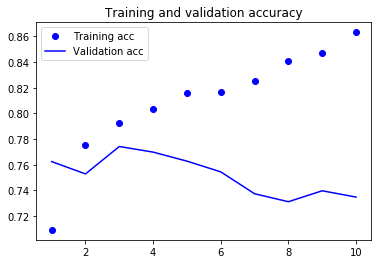

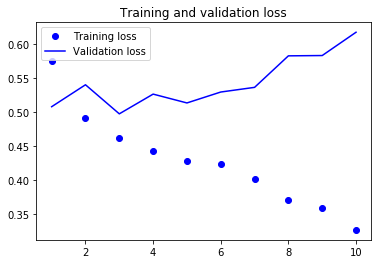

In [97]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Well, looks like we're still over fitting. Not as bad, but still over fitting. Don't worry, we'll address that soon.

### 2.c Model - LSTM - Long Short Term Memory

#### LSTM
The RNN showed good improvement over our first model but SimpleRNN isn't the only recurrent layer available in Keras. In fact, SimpleRNN has a major issue: although it should theoretically be able to retain at time *t* information about inputs seen many timesteps before, in practice such long-term dependencies are impossible to learn. This is due to the vanishing gradient problem, an effect that is similar to what is observed with non-recurrent networks (feedforwad networks) that are many layers deep: as you keep adding layers to a network, the network eventually becomes untrainable. The LSTM layers are designed to solve this problem.

Long Short-Term Memory (LSTM) is a variant fo the SimpleRNN layer we used in the previous model, though LSTM adds a way to carry information across many timesteps. In short, what an LSTM does is save information for later, thus preventing older signals from gradually vanishing during processing. Essentially, it allows past information to be reinjected at a later time, thus fighting the vanishing-gradient problem.

<img src="https://image.slidesharecdn.com/mdrnn-yandexmoscowcv-160427182305/95/multidimensional-rnn-7-638.jpg?cb=1461781453">

<img src="https://image.slidesharecdn.com/mdrnn-yandexmoscowcv-160427182305/95/multidimensional-rnn-11-638.jpg?cb=1461781453">

In [98]:
maxlen = 200 # Cuts off title after X words
max_words = 20000 # considers only the top X words in the dataset

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 32)          640000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 101       
Total params: 693,301
Trainable params: 693,301
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 182s 5ms/step - loss: 0.5317 - acc: 0.7449 - val_loss: 0.4903 - val_acc: 0.7727
Epoch 2/10
40000/40000 [==============================] - 177s 4ms/step - loss: 0.4550 - acc: 0.7977 - val_loss: 0.6035 - val_acc: 0.7416
Epoch 3/10
40000/40000 [==============================] - 177s 4ms/step - 

#### Score our model on the test set

In [100]:
# Final evaluation of the model on test set
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test set accuracy: %.2f%%" % (scores[1]*100))

Test set accuracy: 76.63%


#### We made continued progress on the test set. 73% -> 76%. The LSTM is an improvement over the SimpleRNN.

#### Plot the model's performance over time

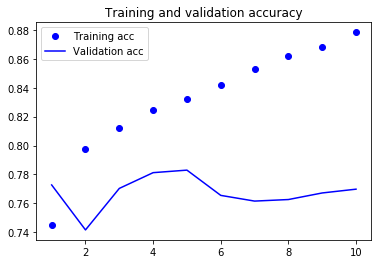

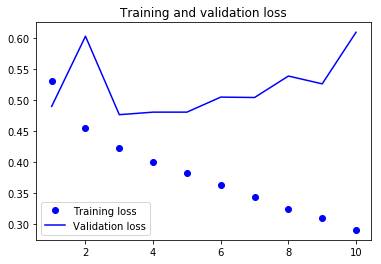

In [99]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Initially, our model started was not overfitting. Up until the 5th epoch we were progressing nicely. Let's see if we can systematically address our overfitting issue.

### 2.d Model - LSTM with Dropout

#### Dropout
It's fairly evident from the previous training and validation curves that the models are overfitting: the training and validation losses start to diverge considerably after a few epochs. A classid technique to fight this phenomenon is dropout. Dropout randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to.

#### Recurrent dropout
To correctly apply dropout in RNNs isn not a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal determined that the proper way to use dropout with a recurrent network is that the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep. Using the same dropout mask at every timestep allows the network to properly propogate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

<img src="https://cdn-images-1.medium.com/max/800/1*IrdJ5PghD9YoOyVAQ73MJw.gif">

In [101]:
maxlen = 200 # Cuts off after X words
max_words = 20000 # considers only the top X words in the dataset

model = Sequential()
model.add(Embedding(max_words, 32))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 32)          640000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 693,301
Trainable params: 693,301
Non-trainable params: 0
_________________________________________________________________
Train on 40000 samples, validate on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 204s 5ms/step - loss: 0.5505 - acc: 0.7329 - val_loss: 0.5162 - val_acc: 0.7688
Epoch 2/10
40000/40000 [==============================] - 229s 6ms/step - loss: 0.4796 - acc: 0.7853 - val_loss: 0.5043 - val_acc: 0.7611
Epoch 3/10
40000/40000 [==============================] - 220s 6ms/step - 

#### Score our model on the test set

In [102]:
# Final evaluation of the model on test set
scores = model.evaluate(x_test, y_test, verbose=0)
print("Test set accuracy: %.2f%%" % (scores[1]*100))

Test set accuracy: 76.81%


#### Minor improvement in accuracy over LSTM without dropout.

#### Plot the model's performance over time

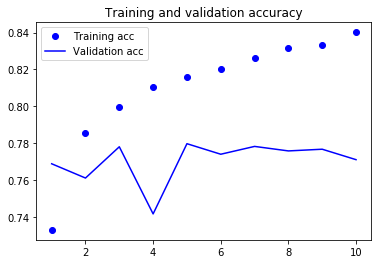

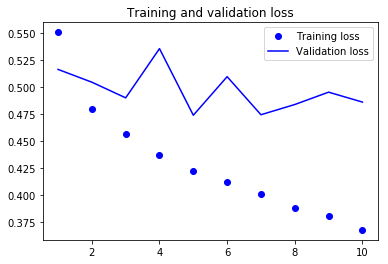

In [103]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Though our validation loss did trend downwards during the training. This signals the model was not overfitting. The validation accuracy was fairly steady but started to tail off towards the end.

## 3. Summary

In our steps today we build a sentiment classifier for off-topic questions on StackOverflow. We started out with essentially some text and their corresponding labels. We took our text and converted it to vectors of integers with each word being its own integer. We then fed that vector into an embedding layer in Keras which in turn outputted a more dense vector of our word representations.

We proceeded to developo a series of models utilizing our word embeddings layer and progressively improved as we went along. For all our models we used the first 200 words from our body text and used only the top 20,000 words (out of a potential ~366,000). Since we are doing a binary classification problem, we used binary_crossentropy as our loss function for all models.

In our first model we built a feedforward network and simply fed the embedding layer into a classifier and we received OK results. Better than random, at least. Though we did see considerable overfitting. In our second model we added a sequencing aspect by using a recurrent network. Our accuracy improved but we still saw some overfitting. In our third model we used an RNN variant called Long Short-Term Memory (LSTM). LSTM has the benefit of addressing of the vanishing gradient problem which can plaugue simple RNNs. Essentially an LSTM will save information for later that can be reinjected at a later time. The LSTM made more progress on our accuracy and improved our overfitting. The final model was and LSTM with dropout. This method systematically addresses the overfitting issue by randomly zeroing out input units of a layer in order to break happenstance correlations in the training data. This method marginally improved our accuracy over plain LSTM but did address our overfitting issue.

## 4. Analysis

1. **How accurate is your method? What metrics besides accuracy might be valuable to examine for solving this problem?**
    - We might consider a confusion matrix and focus on maximizing precision. We want to maximize precision because we care mostly about minimizing False positives. False positives should be minimized because we don’t want to prematurely close a post that has a valid reason to not be closed. If we let in a few False negatives it isn’t that big a deal because the posts can still be closed manually and the platform is not worse for wear. If, on the other hand, we were building a classifier to detect cancer we would care deeply about reducing False negatives and would instead be focused on maximizing recall.
<img src="https://cdn-images-1.medium.com/max/600/1*KhlD7Js9leo0B0zfsIfAIA.png">
2. **The dataset we’ve given you is balanced such that there’s an even split of closed posts to accepted posts. Should this influence the metrics you measure?**
    - Since our data set is balanced along the target variable class, accuracy is a good metric. Accuracy should not be used as a measure when the target variable classes in the data are a majority of one class.    
<br>   
3. **How generalizable is your method? If you were given a different (disjoint) random sample of posts with the same labeling scheme, would you expect it to perform well? Why or why not? Do you have evidence for your reasoning?**
    - Our model generalize well because we use both the validation and test sets to check as we progress. We use the validation set during our training to check for generalization. And we use our held out test set to check how the model performs on unseen data. We also took systematics steps (dropout) to address generalization during the model fitting stage.

<br>

4. **How well would this method work on an entirely new close reason, e.g. duplicate or spam posts?**
    - 'Duplicate' reason was included in the problem description so we should expect the model to perform well on the duplicate use case. If a new close reason is created we would not expect the model to perform well. The model was trained on a specific set of close reasons, so any new reason, not included in the training would be outside of the models capability. This is an active area of research and I recommend checkout this paper discussing the hidden technical debt incurred by machine learning systems. https://papers.nips.cc/paper/5656-hidden-technical-debt-in-machine-learning-systems.pdf

<br>

5. **Are there edge cases that your method tends to do worse with? Better? E.g., How well does it handle really long posts or titles?**
    - Since we only looked at the first 200 words of a body text we could expect very long post to not perform as well.

<br>

6. **If you got to work on this again, what would you do differently (if anything)?**
    - I'd do more hyperparameter tuning (number of layers, batch size, number of words analyzed, etc). I'd also consider using a pre-trained word embedding, such as Word2Vec and GloVe.
    
<br>

7. **Are there any concerns you have with how the dataset was constructed?**
    - Your model is as biased as the data you put into it. For instance, there could be some bias in the people that manually closed these posts and hence created this data. We know developer can have very strong opinions on languages, frameworks, methods, etc., so they could be biasing our training data. Also, we don't know the full machinations of the closing process. Their could be unknown details in the process that is impacting how the data is generated.

## 5. Thoughts and Further Work

1. T-SNE visualization from our word embeddings
2. Given the size of our dataset, TFIDF with logistic regression could be an approach for this use case
3. More engineering on the raw data
4. Use pre-trained word embeddings (i.e. Word2Vec and GloVe)
5. Word cloud visualization
6. Creatively using both title and body. In my analysis body provided the most signal. Perhaps there is a way to combine both title and body.
7. Pass scores that fall within a specific threshold (i.e. 40-60%) to human review. There we might find instances where our model could be improved with some human scrutiny.